#  <span style='color:midnightblue'>  Predicting Movie Revenue with Linear Models </span>

##  <span style='color:royalblue'>  1. Load required libraries </span>

In [85]:
library(ggfortify)
library(dynlm)
library(stargazer)
library(margins)
library(ez)

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


##  <span style='color:royalblue'>  2. Load Dataset </span>

In [86]:
ecommerce_df <- read.csv("./ecommercesales.csv", sep = ";")

##  <span style='color:royalblue'>  3. Inspect dataset </span>

In [87]:
head(ecommerce_df,10)

Day.Index,Revenue,E.commerce.Conversion.Rate,Marketing.Costs,X
01.01.2016,476.95,0.62%,18.80,NA
02.01.2016,453.17,0.59%,38.61,NA
03.01.2016,687.37,0.96%,31.28,NA
04.01.2016,2533.35,1.44%,18.15,NA
05.01.2016,5266.79,1.47%,24.49,NA
06.01.2016,3163.61,2.27%,27.50,NA
07.01.2016,1992.35,1.61%,19.90,NA
08.01.2016,1999.61,1.61%,20.51,NA
09.01.2016,412.62,0.41%,13.26,NA
10.01.2016,1539.81,1.32%,15.65,NA


In [88]:
skimr::skim(ecommerce_df)

Warning message in sorted_count(x):
“Variable contains value(s) of "" that have been converted to "empty".”Warning message in sorted_count(x):
“Variable contains value(s) of "" that have been converted to "empty".”

── Data Summary ────────────────────────
                           Values      
Name                       ecommerce_df
Number of rows             883         
Number of columns          5           
_______________________                
Column type frequency:                 
  factor                   2           
  logical                  1           
  numeric                  2           
________________________               
Group variables            None        

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable              n_missing complete_rate ordered n_unique
1 Day.Index                          0             1 FALSE        882
2 E.commerce.Conversion.Rate         0             1 FALSE        340
  top_counts                     
1 emp: 2, 01.: 1, 01.: 1, 01.: 1 
2 0.0: 12, 2.2: 9, 1.4: 8, 1.5: 8

── Variable type: logical ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  me

##  <span style='color:royalblue'>  4. Compute New Variables and Transform to Time Series </span>

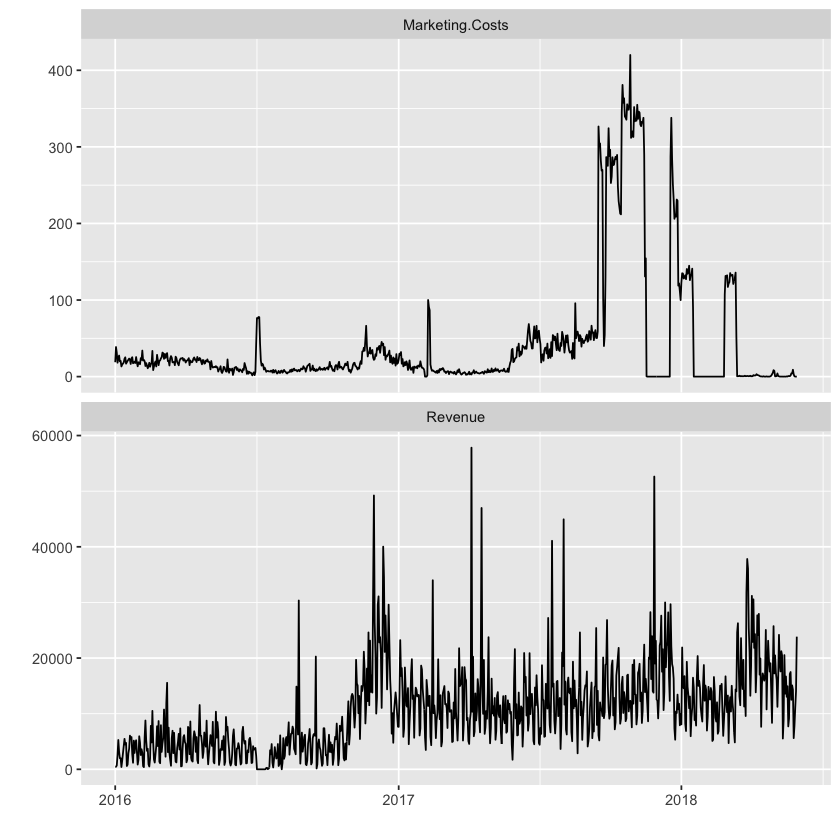

In [89]:
ecommerce_df <- ecommerce_df[,-c(3,5)]
ecommerce_df <- ecommerce_df[-which(ecommerce_df$Day.Index == ""),]
ecommerce_df["Date"] <- as.Date(ecommerce_df$Day.Index, "%d.%m.%Y")
ecommerce_df["Week"] <- lubridate::week(ecommerce_df$Date)
ecommerce_df["Month"] <- lubridate::month(ecommerce_df$Date)
ecommerce_df["Year"] <- lubridate::year(ecommerce_df$Date)

ecommerce_xts.1 <- xts::xts(ecommerce_df$Revenue, order.by = ecommerce_df$Date)
ecommerce_xts.2 <- xts::xts(ecommerce_df$Marketing.Costs, order.by = ecommerce_df$Date)
ecommerce_xts <- cbind(ecommerce_xts.1, ecommerce_xts.2)
colnames(ecommerce_xts) <- c("Revenue", "Marketing.Costs")

ggplot2::autoplot(ecommerce_xts)

##  <span style='color:royalblue'>  5. Aggregate dataframe to Weekly </span>

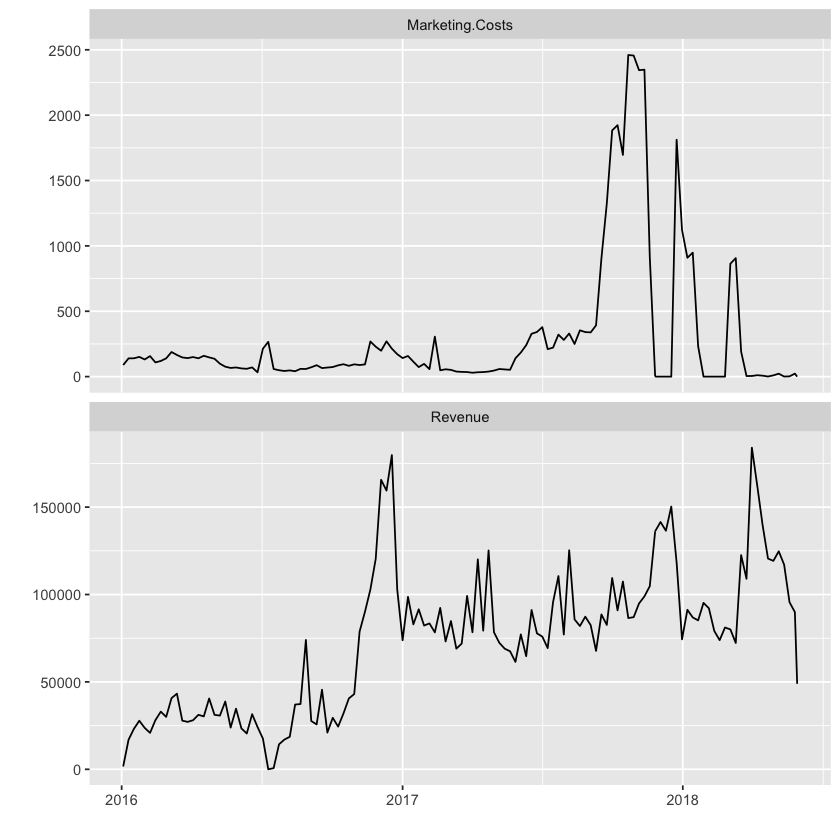

In [90]:
ecommerce_xts.weekly1 <- xts::apply.weekly(ecommerce_xts$Revenue,FUN=sum)
ecommerce_xts.weekly2 <- xts::apply.weekly(ecommerce_xts$Marketing.Costs,FUN=sum)
ecommerce_xts.weekly <- cbind(ecommerce_xts.weekly1, ecommerce_xts.weekly2)
colnames(ecommerce_xts.weekly) <- c("Revenue", "Marketing.Costs")

ggplot2::autoplot(ecommerce_xts.weekly)

##  <span style='color:royalblue'>  6. Fit and Summarize Dynamic Linear Models </span>

In [ ]:
ecommerce_xts.weekly$Month <- lubridate::month(index(ecommerce_xts.weekly))

model_rev1 <- dynlm(Revenue ~ Marketing.Costs + as.factor(Month), 
                           data = ecommerce_xts.weekly[1:100,])
model_rev2 <- dynlm(Revenue ~ Marketing.Costs + as.factor(Month) + L(Revenue, 1), 
                           data = ecommerce_xts.weekly[1:100,])
model_rev3 <- dynlm(Revenue ~ Marketing.Costs + as.factor(Month) + L(Revenue, 1) + 
                      L(Revenue, 2), data = ecommerce_xts.weekly[1:100,])
model_rev4 <- dynlm(Revenue ~ Marketing.Costs + as.factor(Month) + L(Revenue, 1) + 
                      L(Revenue, 2) + L(Revenue, 3), data = ecommerce_xts.weekly[1:100,])

stargazer::stargazer(model_rev1, model_rev2, model_rev3, model_rev4, type = "html", report = "vc*", star.cutoffs = c(.05, .01, .001), out = "table2.html")

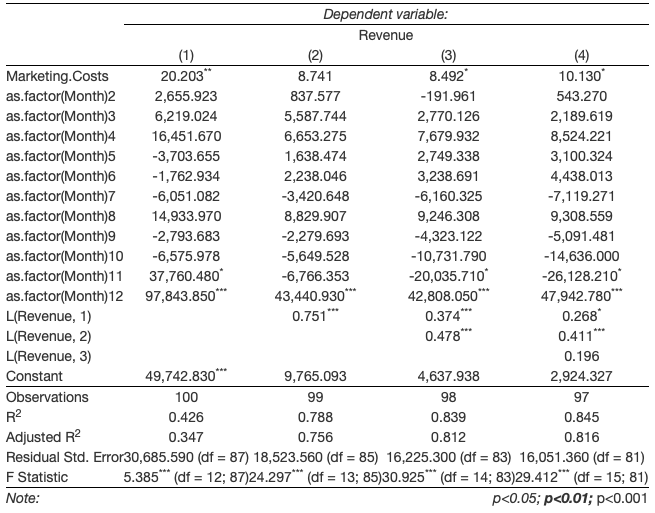

##  <span style='color:royalblue'>  7. Plot Fitted Values for 100 Weeks </span>

In [ ]:
fitted <- fitted(model_rev4)
fitted_xts <- xts::as.xts(fitted)

plot(ecommerce_xts.weekly$Revenue)

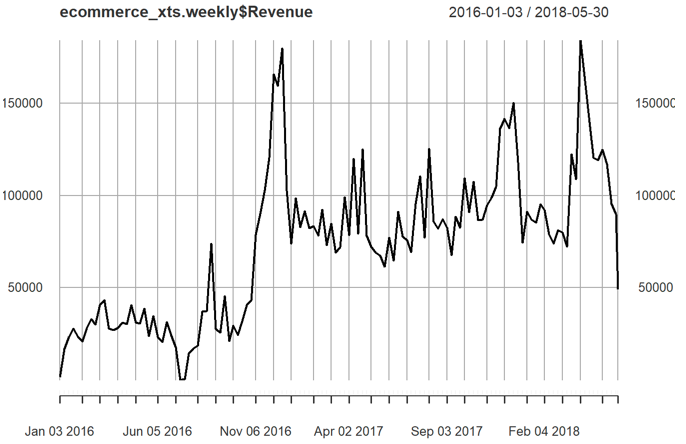

In [ ]:
lines(fitted_xts, col = 2, lty = 2, lwd = 3)

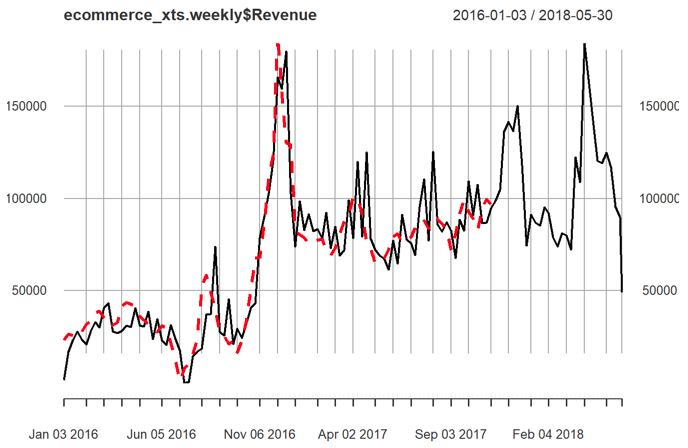

##  <span style='color:royalblue'>  8. Compute and Plot Predictions for Remaining Weeks </span>

In [ ]:
prediction <- predict(model_rev4, newdata = ecommerce_xts.weekly[101:127,])
prediction_xts <- xts::xts(prediction, order.by = as.Date(names(prediction)))

plot(ecommerce_xts.weekly$Revenue)

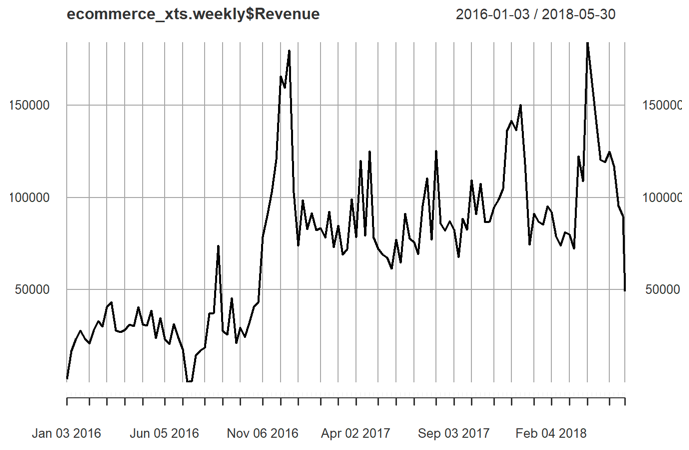

In [ ]:
lines(prediction_xts, col = 2, lty = 2, lwd = 3)

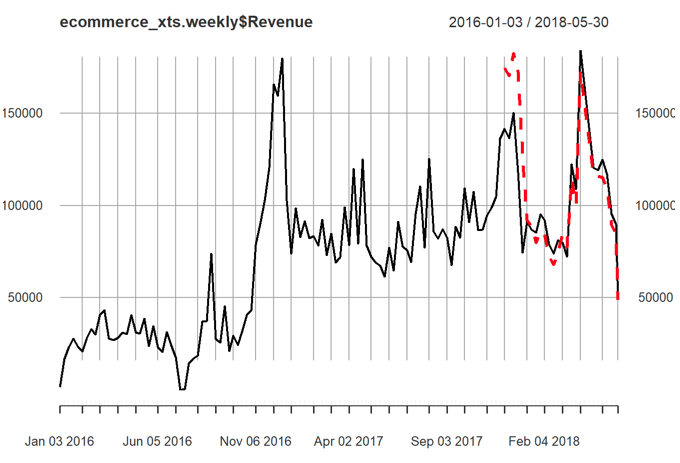